### decision tree pruning

We can prune decision trees. We do this by imposing a penalty per split. This amounts to defining a new loss function, say (for a regressor)

tree_score = SSE + $\alpha$ \* n_leaves.

When $\alpha=0$, this is just the old loss function. If $\alpha$ is high, this new loss function penalizes a tree for additional leaves. We then have $\alpha$ as a hyperparameter which controls overfit and can be optimized experimentally, just as with max_depth.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from multiprocessing import Pool

In [2]:
df = pd.read_csv('/home/briggsc1-erau.edu/Downloads/housing.csv')
features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
target = ['median_house_value']
df = df.dropna(subset = features+target)

Using our full dataset with a normally-sized training set, we may run into memory limitations. Try it and see. If so, use a smaller training set. I have split train-val-test 20-40-40 here.

In [3]:
x_tr,x_te,y_tr,y_te = train_test_split(df[features],df[target],
                                       test_size = 0.8, random_state = 0)
x_va,x_te,y_va,y_te = train_test_split(x_te,y_te,
                                       test_size = 0.5, random_state = 0)

The way we start is to fit a tree to some data, then increase alpha from 0 until some leaf is eliminated. We store this value of alpha, the leaf which was eliminated, and the SSE. We then continue to increase alpha until another leaf is eliminated. And so on, until we arrive at the trivial tree (one leaf, null model).

In [4]:
tr = DecisionTreeRegressor(random_state=0)
path = tr.cost_complexity_pruning_path(x_tr, y_tr)
ccp_alphas, SSE = path.ccp_alphas, path.impurities

As alpha increases, of course SSE (on the training set) will increase.

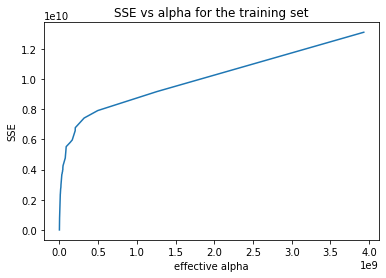

In [5]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas, SSE)
ax.set_xlabel('effective alpha')
ax.set_ylabel('SSE')
ax.set_title('SSE vs alpha for the training set');

We can supply an alpha to the function which instantiates a tree. This redefines the loss function of the tree by incorporating a leaf penalty with coefficient alpha. We'll train a tree for each of our stored alphas. Multiprocessing will help things to run in a reasonable time.

In [6]:
def fit_tree(alpha):
    tr = DecisionTreeRegressor(random_state=0, ccp_alpha=alpha)
    tr.fit(x_tr, y_tr)
    return(tr)
with Pool(processes = 15) as p:
    trees = p.map(fit_tree,ccp_alphas)

Now we'll get the training and validation scores for each tree.

In [8]:
data = []
for tr in trees:
    alpha = tr.ccp_alpha
    acc_tr = tr.score(x_tr,y_tr)
    acc_va = tr.score(x_va,y_va)
    n_leaves = tr.get_n_leaves()
    depth = tr.get_depth()
    data.append({'alpha':alpha,'depth':depth,'n_leaves':n_leaves,
                 'acc_tr':acc_tr,'acc_va':acc_va})
df_acc = pd.DataFrame(data)
df_acc.head()

,alpha,depth,n_leaves,acc_tr,acc_va
0,0.000000,28,3927,1.0,0.566926
1,0.000163,28,3926,1.0,0.566926
2,0.000184,28,3924,1.0,0.566926
3,0.000184,28,3924,1.0,0.566926
4,0.000204,28,3923,1.0,0.566926


We can look at how alpha is affecting the number of leaves and the depth.

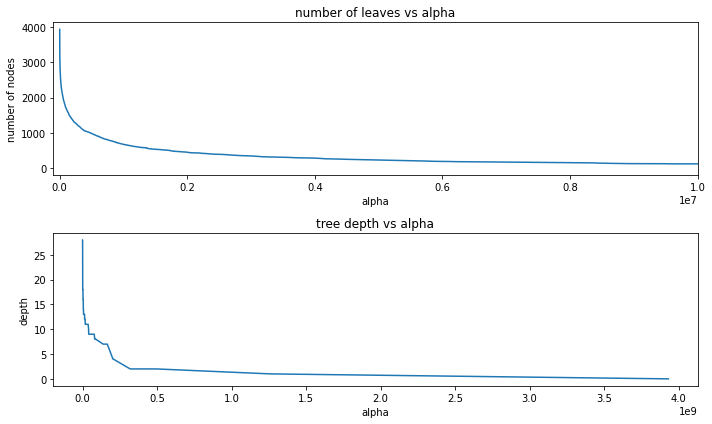

In [15]:
fig, ax = plt.subplots(2, 1,figsize = (10,6))
ax[0].plot(df_acc.alpha, df_acc.n_leaves)
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('number of nodes')
ax[0].set_title('number of leaves vs alpha')
ax[1].plot(df_acc.alpha, df_acc.depth)
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('depth')
ax[1].set_title('tree depth vs alpha')
ax[0].set_xlim(-10**5,10**7)
fig.tight_layout();

We are most interested in how alpha affects the accuracy of the tree on the validation set.

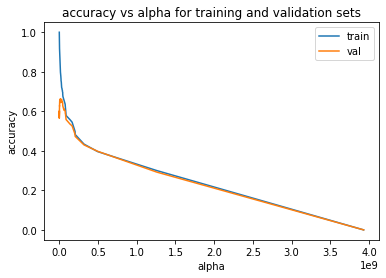

In [21]:
fig, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('accuracy vs alpha for training and validation sets')
ax.plot(df_acc.alpha, df_acc.acc_tr, label='train')
ax.plot(df_acc.alpha, df_acc.acc_va, label='val')
ax.legend()
plt.show()

This graph is a characteristic for optimizing hyperparameters: there is a monotonic decrease in accuracy for the training set while the validation set has an optimum somewhere in the middle. We locate the best alpha for accuracy on the validation set.

In [22]:
best_idx = df_acc['acc_va'].idxmax()
best_row = df_acc.loc[best_idx]
best_row

alpha       1.311190e+07
depth       1.300000e+01
n_leaves    1.020000e+02
acc_tr      8.107542e-01
acc_va      6.615858e-01
Name: 3541, dtype: float64

Finally, we can measure the accuracy on the test set.

In [23]:
trees[best_idx].score(x_te,y_te)

0.674751413996367